In [171]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML

In [269]:
"""
Tree-like object.
"""
class Tree():
    def __init__(self, root, dx, dy, ax=None, **kwargs):
        self.root = root
        self.leaves = [root]
        self.dx = dx
        self.dy = dy
        self.style = kwargs
        self.ax = ax
        #root.draw()
    def add_layer(self, plot=False):
        new_leaves = []
        for leaf in self.leaves:
            leaf.left = Node([leaf.val[0]-self.dx, leaf.val[1]-self.dy], leaf)
            leaf.right = Node([leaf.val[0]+self.dx, leaf.val[1]-self.dy], leaf)
            # draw the new branches
            if plot:
                leaf.left.draw(self.ax, **self.style)
                leaf.right.draw(self.ax, **self.style)
            if len(new_leaves) and leaf.left.val == new_leaves[-1].val:
                new_leaves.pop()
                new_leaves.append(leaf.right)
            else:
                new_leaves += [leaf.left, leaf.right]
        self.leaves = new_leaves
        
    def add_layers(self, n, plot=False):
        for _ in range(n):
            self.add_layer(plot)


class Node():
"""Nodes of a tree"""
    def __init__(self, value, parent=None, left=None, right=None):
        self.par = parent
        self.val = value
        self.left = left
        self.right = right
    def draw(self, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
        if self.par is None:
            ax.scatter(self.val[0], self.val[1], **kwargs)
        else:
            ax.plot([self.par.val[0], self.val[0]], [self.par.val[1], self.val[1]], **kwargs)
            
            
def dfs(node):
    """traditional depth-first tree search (left branch, then node, then right branch)"""
    if node is not None:
        yield from dfs(node.left)
        yield node
        yield from dfs(node.right)
    return lst

def preorder(node):
    """pre-order tree search (node, left branch, then right branch)"""
    if node is not None:
        yield node
        yield from preorder(node.left)
        yield from preorder(node.right)

def postorder(node):
    """post-order.  Left, right, node"""
    if node is not None:
        yield from preorder(node.left)
        yield from preorder(node.right)
        yield node
        
def ubfs(node):
    """Upside-down breadth-first search"""
    nodes = list(bfs(node))
    nodes.reverse()
    for node in nodes:
        yield node
        
def bfs(node):
    """breadth-first search"""
    if node is None:
        return
    queue = [node]
    while len(queue) > 0:
        yield queue[0]
        temp = queue.pop(0)
        
        if temp.left is not None:
            queue.append(temp.left)
        if temp.right is not None:
            queue.append(temp.right)

In [279]:
def frames(nodes, n):
    """
    Generator of frames for animation.
    
    i is the node, j is the animation step for that node.
    """
    for i, node in enumerate(nodes):
        for j in range(n):
            yield node, i, j

def animate_sierpinsky(tree, order, N, interval=20, save_count=10**4):
    """
    Animate drawing the triangle using the ordering order.
    
    order is a generator returning the nodes in the order you want.
    """
    
    nodes = order(tree.root)

    # the sweep for each new edge
    r = np.sqrt(dx**2+dy**2)
    final = np.pi + np.arctan(dy/dx)

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, aspect='equal')
    line,  = ax.plot([], [], lw=2)
    lines = [line]
    dthetas = np.linspace(0, np.sqrt(final-np.pi/2), N)**2
    n = 0

    # initialization function: plot the background of each frame
    def init():
        lines[-1].set_data([], [])
        return lines

    # animation function.  This is called sequentially
    def animate(nodeij):
        global thetas
        node, i, j = nodeij
        if node.par is None:  # root
            return lines
        if j == 0:    # new node
            if i == 0:
                #first node, set axis lims
                ax.set_xlim(min(node.val[0], node.par.val[0])-dx, max(node.val[0], node.par.val[0])+dx)
                ax.set_ylim(min(node.val[1], node.par.val[1])-dy, max(node.val[1], node.par.val[1])+dy)
            # rescale xlim/ylim as needed
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            if node.val[0] > xlim[1]:
                ax.set_xlim(xlim[0], node.val[0]+dx)
            elif node.val[0] < xlim[0]:
                ax.set_xlim(node.val[0]-dx, xlim[1])
            if node.val[1] < ylim[0]:
                ax.set_ylim(node.val[1]-dy, ylim[1])
            elif node.par.val[1] > ylim[1]:
                ax.set_ylim(ylim[0], node.par.val[1]+dy)

            # is it a right or left:
            if node.val[0] > node.par.val[0]:  # right
                thetas = np.pi/2 - dthetas
            else:
                thetas = np.pi/2 + dthetas

            new_line, = ax.plot([], [], lw=2)
            lines.append(new_line)
        theta = thetas[j]
        lines[-1].set_data([node.par.val[0], r*np.cos(theta)+node.par.val[0]], 
                           [node.par.val[1], r*np.sin(theta)+node.par.val[1]])
        return lines
    plt.axis('off')
    # call the animator.  blit=True means only re-draw the parts that have changed.
    return animation.FuncAnimation(fig, animate, init_func=init, repeat=False, save_count=save_count,
                                   frames=frames(nodes, N), interval=interval, blit=True)

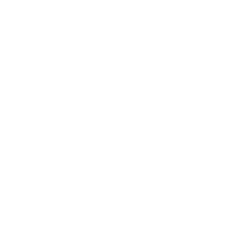

In [282]:
# Run it
N=3  # number of animation steps per branch
L = 30  # number of layers of tree to animate
o = postorder  # order to draw the tree -- dfs, bfs, ubfs, preorder, postorder

dx, dy = (1, 1)  # the length/width of your branches
tree = Tree(Node([0,0]), dx, dy)  # initiate a tree with an origin at 0,0
tree.add_layers(L)  # grow the tree
anim = animate_sierpinsky(tree, o, N, interval=10, save_count=10**4)  # animate the drawing 

In [283]:
HTML(anim.to_html5_video())

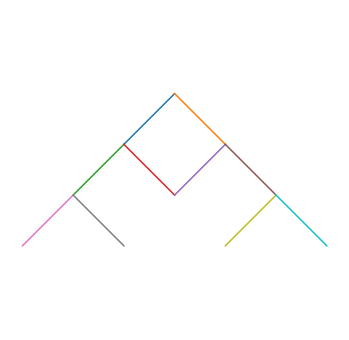

In [270]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
tree = Tree(Node([0,0]), 1, 1, ax=ax)
tree.add_layers(3, plot=True)
plt.axis('off')
plt.axis('equal')
plt.show()

In [271]:
nodes = ubfs(tree.root)
for pt in nodes:
    print(pt.val)

[3, -3]
[1, -3]
[-1, -3]
[-3, -3]
[2, -2]
[0, -2]
[0, -2]
[-2, -2]
[1, -1]
[-1, -1]
[0, 0]


In [267]:
bfs(node)

<generator object bfs at 0x7fb4702eeb50>

In [268]:
list(bfs(node))